In [519]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [520]:
data = pd.read_csv("data.csv")

In [521]:
data

,A,B1,B2,A_doithu,B_doithu
0,0,0,0,180315,5403820
1,0,0,0,293248,11458146
2,0,0,0,177016,18438880
3,0,0,0,327871,10013404
4,735,450,560,181098,4864172
5,330,350,600,270405,10889213
6,560,360,630,90514,4774831
7,750,420,805,355380,9768208
8,730,450,850,202572,6012674
9,450,400,750,244208,9402112


In [522]:
data_train = data.iloc[4:11]
data_test = data.iloc[11:15]

In [523]:
def Yule_Walker(data, order = 1, step = 1):
    R = []
    data = pd.DataFrame(data)
    mean = data.mean()
    for i in range(order+step):
        tmp = 0 
        for j in range(len(data)-i):
            tmp += np.array(data.iloc[j] - mean, ndmin = 2, dtype = float).transpose() @ np.array(data.iloc[j+i] - mean, ndmin = 2, dtype = float) 
        tmp = tmp /len(data)
        R.append(tmp) 
    S0f = R[0]
    S0b = R[0]
    Anew = [R[step] @ np.linalg.inv(S0b)]
    Bnew = [R[step].transpose() @ np.linalg.inv(S0f)]
    App = Anew[0]
    Bpp = Bnew[0]
    for i in range(order-1):
        S0f = (np.eye(len(data.columns)) - App @ Bpp ) @ S0f
        S0b = (np.eye(len(data.columns)) - Bpp @ App ) @ S0b     
        Aold = Anew
        Bold = Bnew
        App = (R[i+step+1] - sum([Aold[j] @ R[i+step+1-j-1] for j in range(i+1)])) @ np.linalg.inv(S0b)
        Bpp = (R[i+step+1].transpose()- sum([Bold[j] @ R[i+step+1-j-1].transpose() for j in range(i+1)])) @ np.linalg.inv(S0f)
        Anew = []
        Bnew = []        
        for j in range(i+1):
            A_tmp = Aold[j] - App @ Bold[i-j]
            B_tmp = Bold[j] - Bpp @ Aold[i-j] 
            Anew.append(A_tmp)
            Bnew.append(B_tmp)
        Anew.append(App)
        Bnew.append(Bpp)  
    return Anew, Bnew, S0f, S0b, R  

def Yule_Walker_pre(coeff, data, data_mean = 0):
    results = []
    data = pd.DataFrame(data)
    data_mean = np.array(data_mean)
    for i in range(len(data)-len(coeff)):
        tmp = 0
        for j in range(len(coeff)):
            tmp += coeff[j] @ np.array(data.iloc[i + (len(coeff))-j-1] - data_mean).transpose()
        results.append(tmp + data_mean)
    return results       

def Yule_Walker_score(coeff, data, data_mean = 0, step = 1, use_train = False, data_test = None):
    predict=[]
    if use_train == False:        
        if(len(coeff) + step > len(data)):
            print("Không đủ quan sát để dự báo")
            return -1,-1,-1
        data = pd.DataFrame(data)
        data_mean = np.array(data_mean)    
        true_results = data.iloc[ (len(coeff) + step -1):]
        results = Yule_Walker_pre(coeff, data, data_mean)[:len(true_results)] 
        print(true_results)
        print(pd.DataFrame(results)) 
    else:
        data = pd.DataFrame(data)
        data_mean = np.array(data_mean)    
        true_results = pd.DataFrame(data_test)
        results = Yule_Walker_pre_train(coeff, data, data_mean, pre_len = len(data_test)) 
        print(true_results)
        print(pd.DataFrame(results)) 
    R_2 = [i*0 for i in range(len(data.columns))]
    MAE = [i*0 for i in range(len(data.columns))]
    MSE = [i*0 for i in range(len(data.columns))]
    for j in range(len(MAE)):
        MSE[j] = 1/len(true_results)* sum([(true_results.iloc[i][j] -results[i][j])**2 for i in range(len(true_results))])
        MAE[j] = 1/len(true_results)* sum([abs(true_results.iloc[i][j] -results[i][j]) for i in range(len(true_results))])
        R_2[j] =1- sum([(true_results.iloc[i][j] -results[i][j])**2 for i in range(len(true_results))])  / (sum([(true_results.iloc[i][j] - 1/len(true_results)* sum([true_results.iloc[k][j] for k in range(len(true_results))]))**2 for i in range(len(true_results))]))
    return MSE, MAE, R_2
   
def Yule_Walker_pre_train(coeff, data_train, data_mean = 0, pre_len = 1):
    if len(coeff) > len(data_train):
        print("Không đủ quan sát.")
        return 0
    results = []
    data = pd.DataFrame(data_train)
    begin = len(data) - len(coeff)
    data_mean = np.array(data_mean)
    for i in range(pre_len):
        tmp = 0
        for j in range(len(coeff)):
            tmp += coeff[j] @ np.array(data.iloc[begin + i + (len(coeff))-j-1] - data_mean).transpose()
        results.append(list(tmp + data_mean))
        data = pd.concat([data, pd.DataFrame([tmp + data_mean], columns = data.columns ) ], axis=0, ignore_index=True)
    return results 
              

In [524]:
data_use = data_train
A, _, _, _, R = Yule_Walker(data_use, 1, step =1)
MSE, MAE, R_2 = Yule_Walker_score(A, data_use, data_use.mean(), step = 1, use_train=True, data_test= data_test)
MAE

      A   B1    B2  A_doithu  B_doithu
11  450  400   750    279109   7350389
12  555  650  1050    336751   3838228
13  600  470   850    252855   6486889
14  400  550   350    306091   7652448
            0           1           2              3             4
0  449.340550  411.411837  782.224018  236393.924138  9.839993e+06
1  776.865252  470.071554  826.066088  249539.478575  7.222082e+06
2  677.781166  420.657850  838.391658  237209.954691  8.343528e+06
3  513.687742  378.798965  706.517234  208693.290910  8.556590e+06


[103.49840233487289,
 102.97086713841762,
 156.07087650023956,
 60742.3379217169,
 2158559.8054274116]

In [525]:
prediction = Yule_Walker_pre_train(A, data_use, data_mean = data_use.mean(), pre_len = 4)

In [526]:
def plot_evaluate(train, test, prediction):
    train_range = list(range(4, len(train) + 4))
    test_range  = list(range(len(train) + 4, len(train) + len(test) + 4))
    prediction_range = list(range(len(train) + len(test) + 4 , len(train) + len(test) + 4 + len(prediction)))
    markers = ['o', 'v', '^', 's', 'p']

    figre, axs = plt.subplots(1, len(train.columns), figsize = (30, 7))
    for i, feature in enumerate(train.columns):
        axs[i].plot(train_range, train[feature], label=f'Train-{feature}', marker=markers[i])
        if len(test)> 0:
            axs[i].plot(test_range, test[feature], label=f'Test-{feature}', marker=markers[i])
            axs[i].plot(test_range, [sublist[i] for sublist in prediction], label=f'Predict-{feature}', marker=markers[i])            
        else:    
            axs[i].plot(prediction_range, [sublist[i] for sublist in prediction], label=f'Predict-{feature}', marker=markers[i])

        axs[i].set_xlabel('time')
        axs[i].set_ylabel(feature)
        axs[i].set_title(f'Biểu đồ biểu diễn {feature}')
        axs[i].legend()
        axs[i].grid(True)
        # axs[i].show()
    return figre

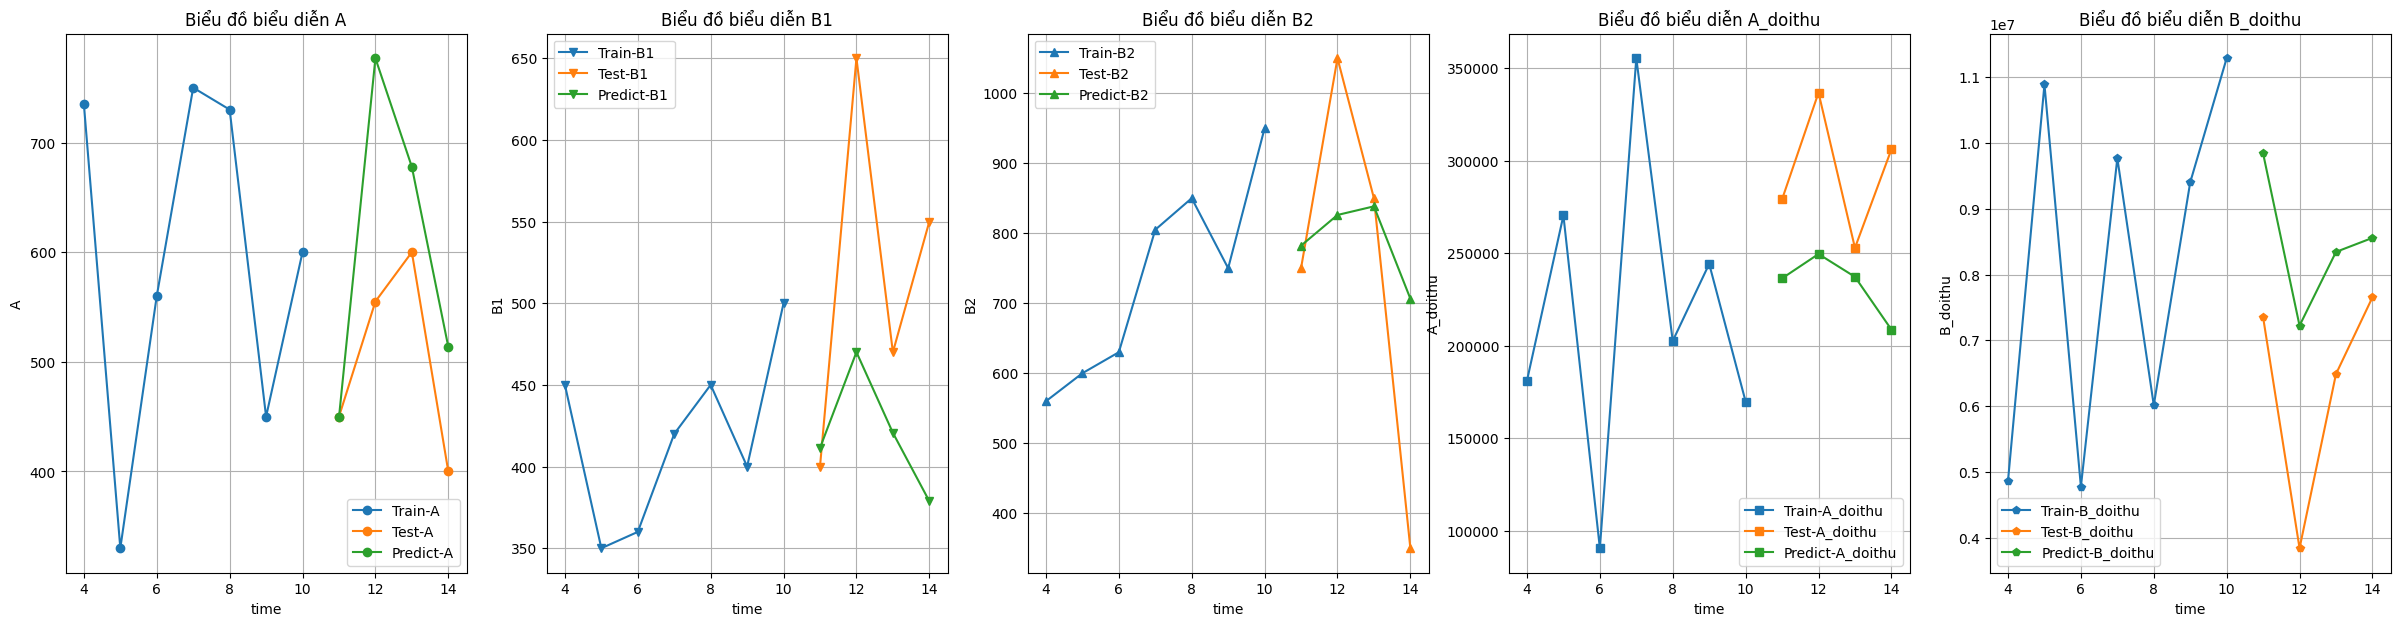

In [527]:
figre = plot_evaluate(data_use, data_test, prediction=prediction)

In [528]:
features = ['A', 'A_doithu']
data_use = data_train[features]
data_eval = data_test[features]
A, _, _, _, R = Yule_Walker(data_use, 1, step =1)
MSE, MAE, R_2 = Yule_Walker_score(A, data_use, data_use.mean(), step = 1, use_train=True, data_test= data_eval)
MAE

      A  A_doithu
11  450    279109
12  555    336751
13  600    252855
14  400    306091
            0              1
0  543.332327  249334.034615
1  639.173268  190031.266338
2  556.125780  237462.312545
3  623.933161  199141.144060


[111.32824382463102, 74709.31061022794]

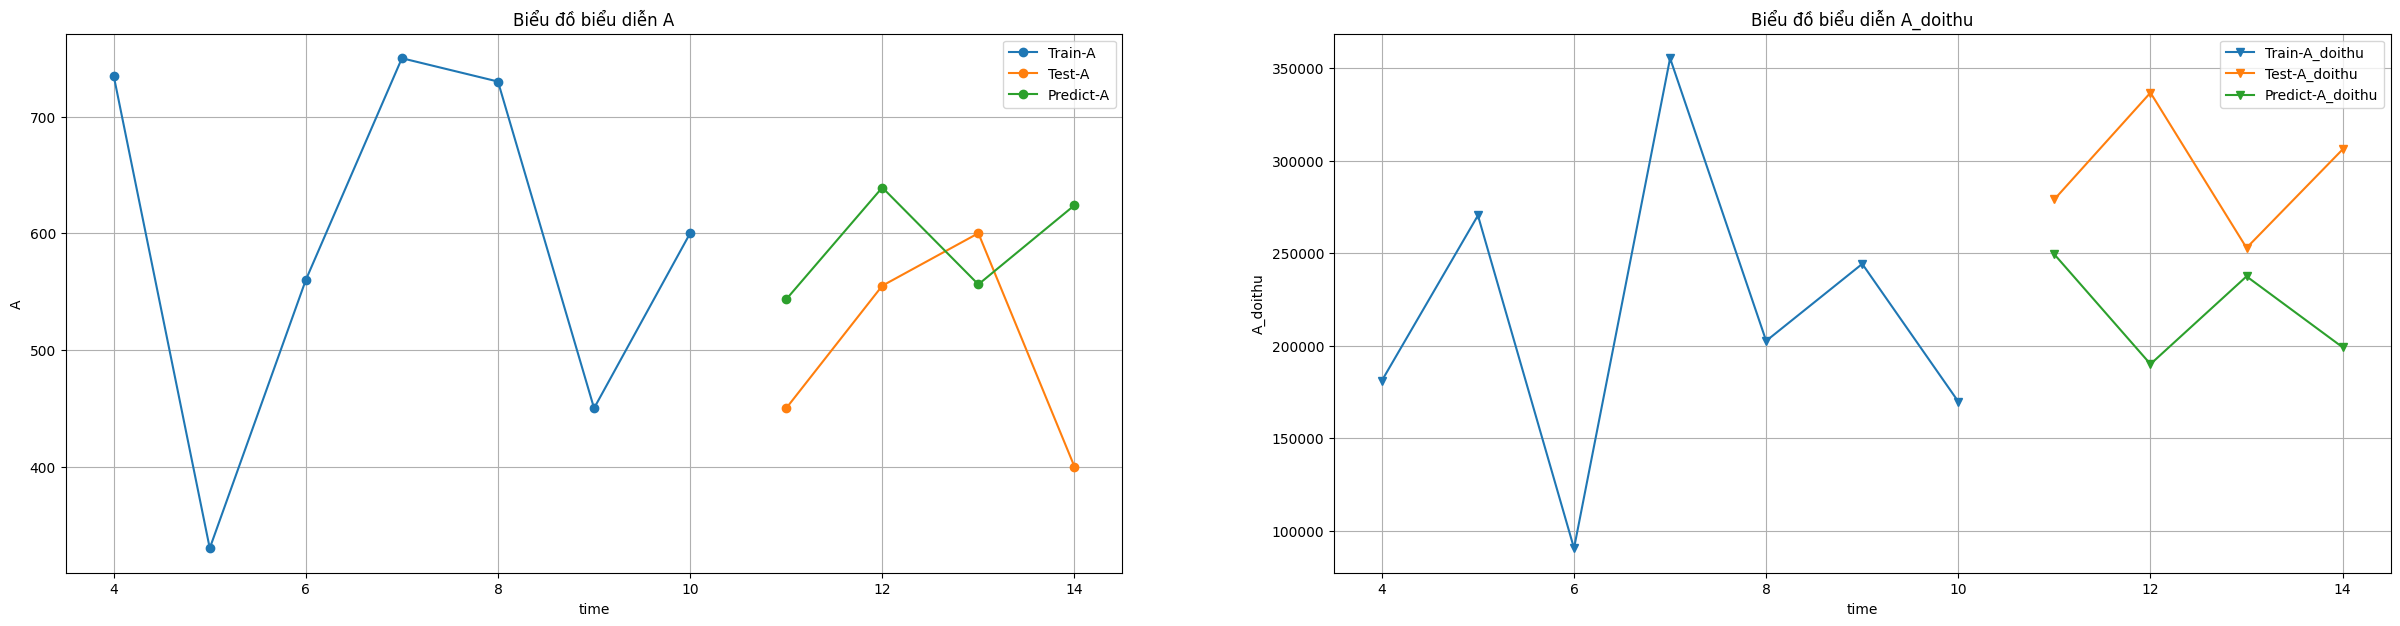

In [529]:
prediction = Yule_Walker_pre_train(A, data_use, data_mean = data_use.mean(), pre_len = 4)
figre = plot_evaluate(data_use, data_eval, prediction=prediction)

In [530]:
features = ['B1', 'B2', 'B_doithu']
data_use = data_train[features]
data_eval = data_test[features]
A, _, _, _, R = Yule_Walker(data_use, 1, step =1)
MSE, MAE, R_2 = Yule_Walker_score(A, data_use, data_use.mean(), step = 1, use_train=True, data_test= data_eval)
MAE

     B1    B2  B_doithu
11  400   750   7350389
12  650  1050   3838228
13  470   850   6486889
14  550   350   7652448
            0           1             2
0  427.221165  823.309317  7.869744e+06
1  403.826993  764.368032  9.170448e+06
2  417.747622  718.532907  7.618115e+06
3  417.113677  735.723152  8.384952e+06


[114.63321804799527, 219.03288259758085, 1928826.1461186484]

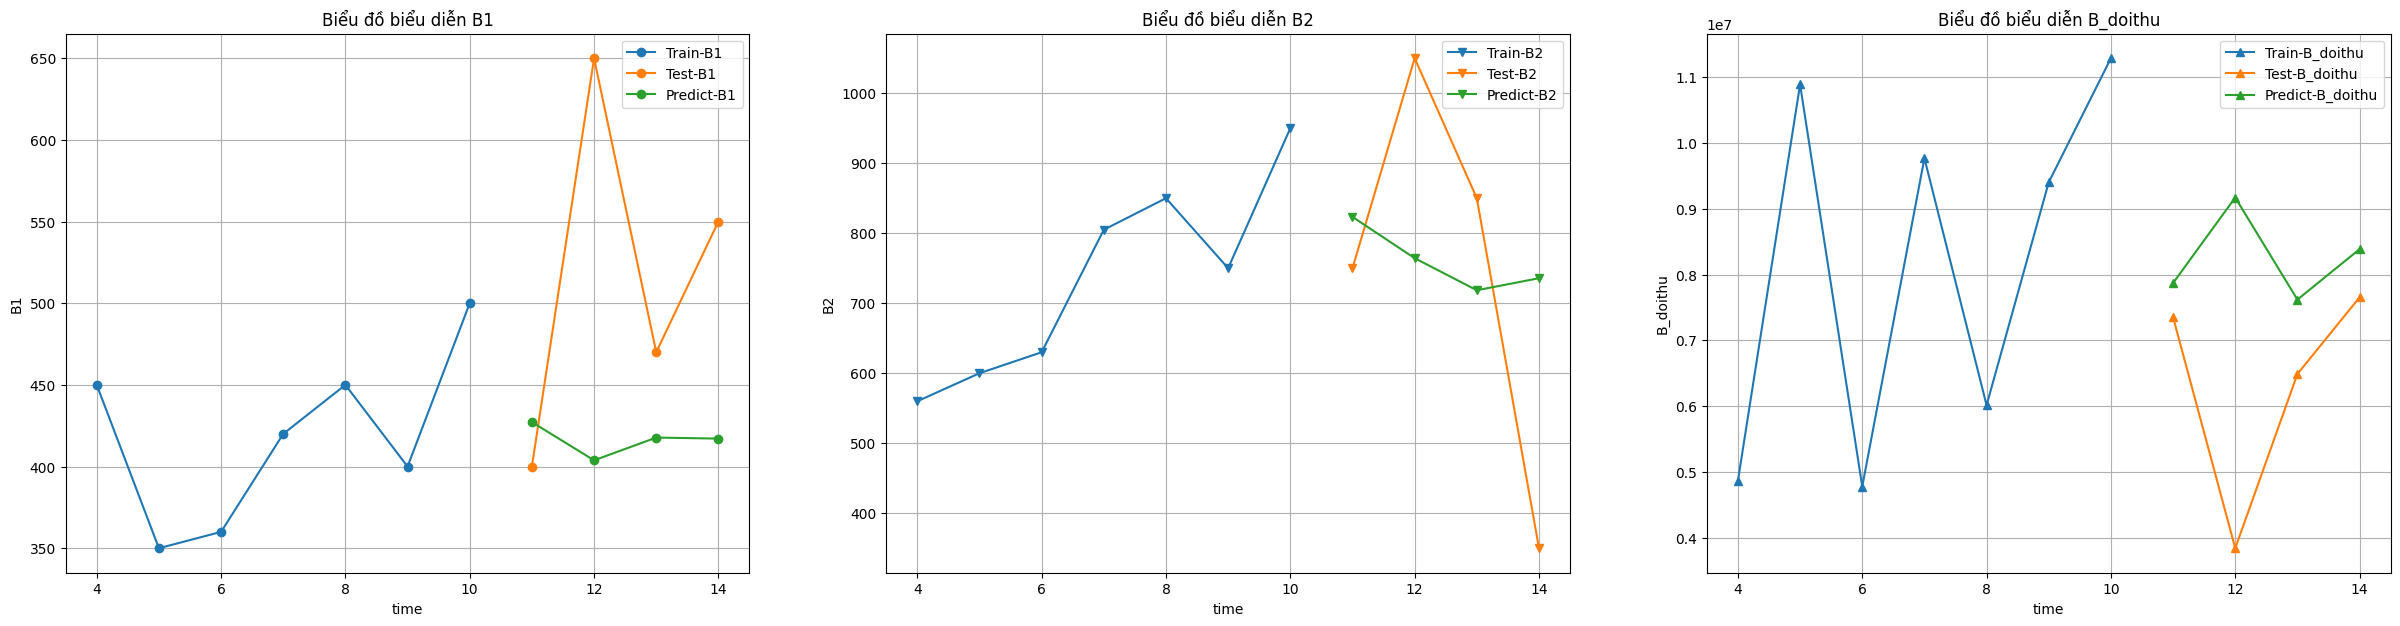

In [531]:
prediction = Yule_Walker_pre_train(A, data_use, data_mean = data_use.mean(), pre_len = 4)
figre = plot_evaluate(data_use, data_eval, prediction=prediction)

Dự báo 4 quý tiếp theo 

In [532]:
#Định nghĩa một số hàm cần dùng
def plot_predict(prediction, data_name):
    markers = ['o', 'v', '^', 's', 'p']
    
    figre, axs = plt.subplots(1, len(data_name), figsize = (35, 7))
    for i, feature in enumerate(data_name):
        axs[i].plot([sublist[i] for sublist in prediction], label=f'Predict-{feature}', marker=markers[i])
        axs[i].set_xlabel('time')
        axs[i].set_ylabel(feature)
        axs[i].set_title(f'Dự báo {feature}')
        axs[i].legend()
        axs[i].grid(True)
        # axs[i].show()
    return figre    

[[587.9289968146843,
  476.45937083067247,
  761.2378053685125,
  239510.4390314386,
  5799527.913878519],
 [529.1764108534583,
  458.48727266217105,
  760.9540030267669,
  271257.4666271042,
  7956737.484573902],
 [580.7091200813146,
  460.7104973804227,
  747.7932887135416,
  229189.16557233874,
  7025864.153489286],
 [540.6751374307636,
  451.2929624992695,
  741.7191202349766,
  258889.88204120443,
  7832721.81148047],
 [575.5991289304435,
  457.9792285690936,
  741.555390515525,
  232923.17032631335,
  7195879.3470362]]

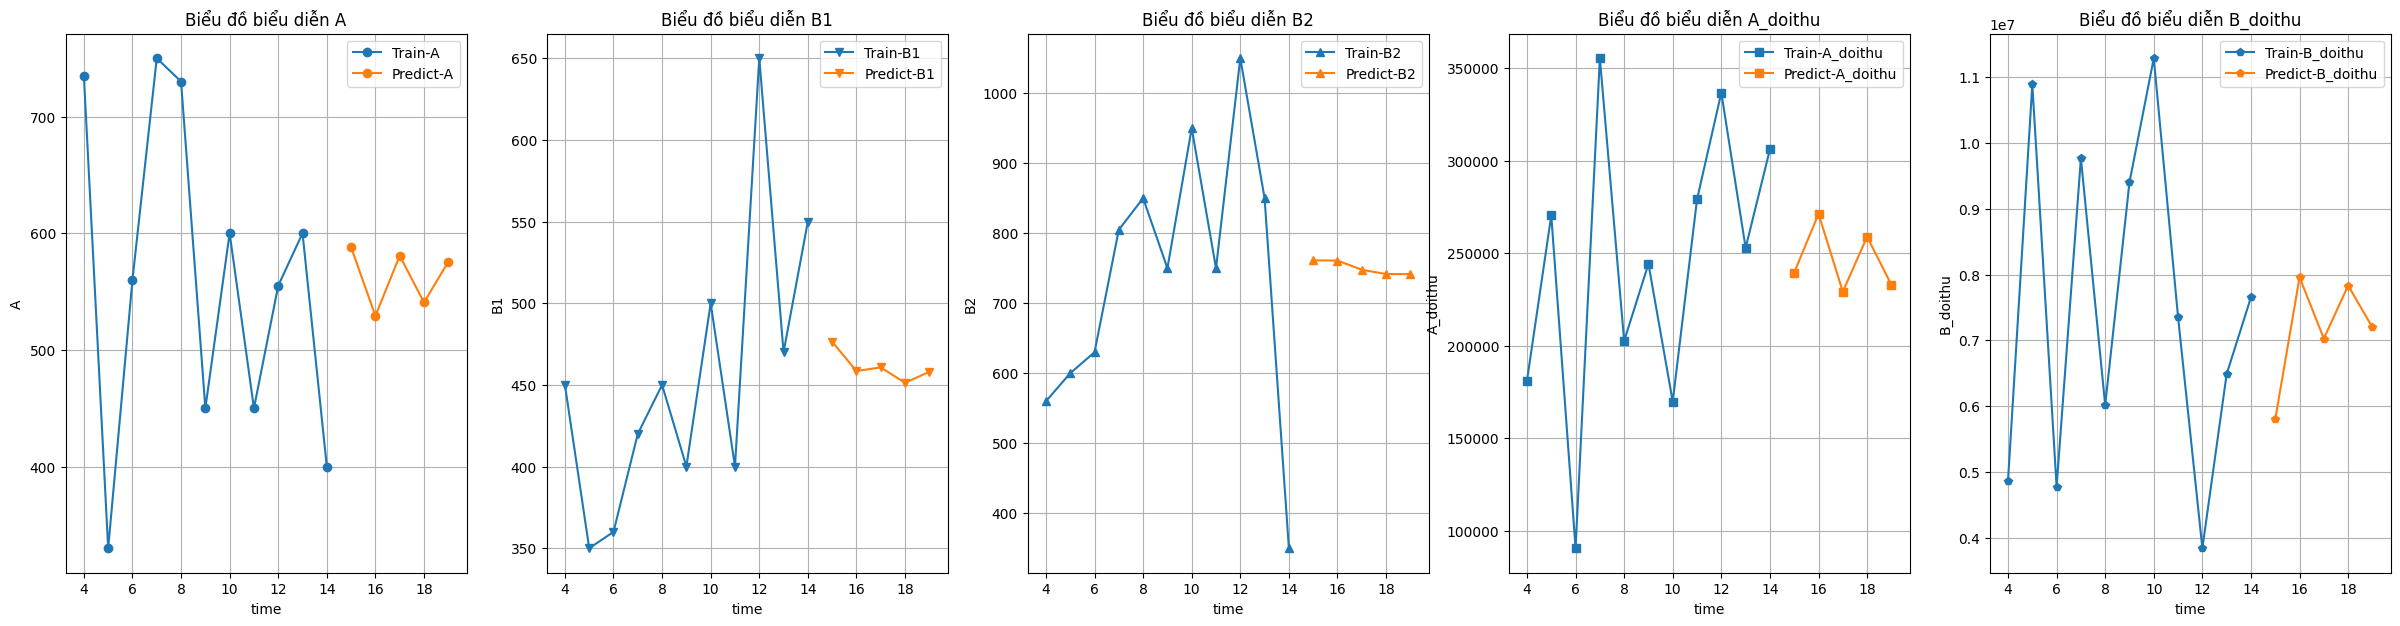

In [533]:
data_use = data.iloc[4:15]
A, _, _, _, R = Yule_Walker(data_use, 1, step =1)
f = plot_evaluate(data_use, [],Yule_Walker_pre_train(A, pd.DataFrame(data_use), np.array(data_use.mean()), pre_len = 5))
Yule_Walker_pre_train(A, pd.DataFrame(data_use), np.array(data_use.mean()), pre_len = 5)


[[615.8204691203388, 211108.75056489985],
 [534.6378222981044, 260718.82425746525],
 [572.0947607586206, 236579.6870278968],
 [554.1896492429555, 248210.33407816367],
 [562.7943289123604, 242614.48635405584]]

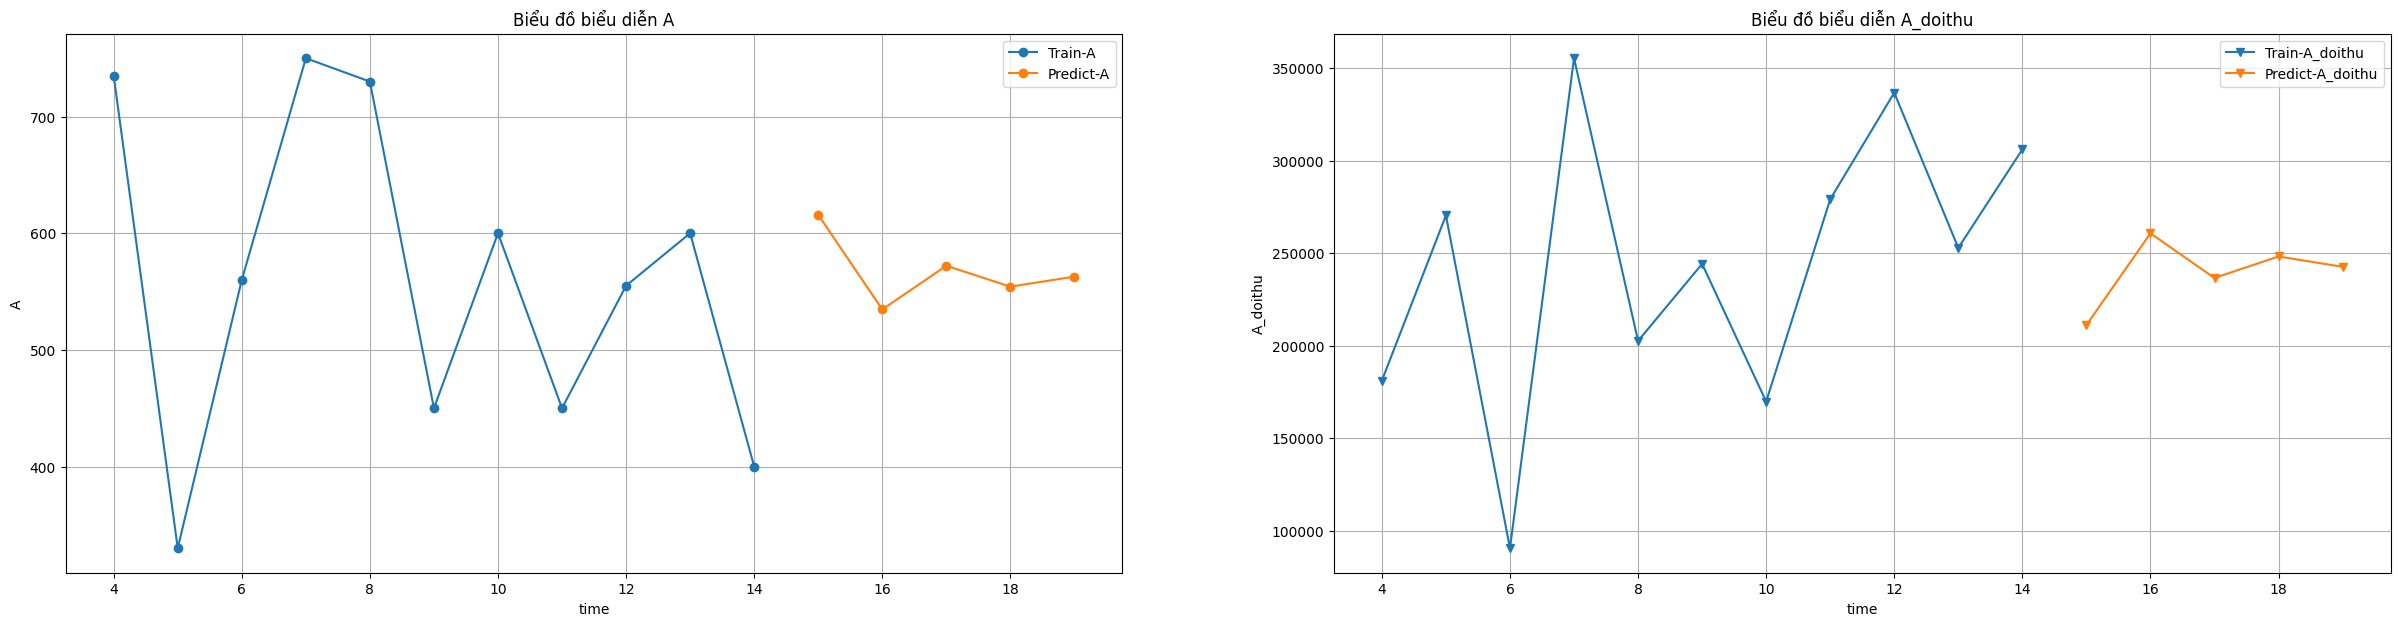

In [534]:
features = ['A', 'A_doithu']
data_use = data.iloc[4:15][features]
data_eval = data_test[features]
A, _, _, _, R = Yule_Walker(data_use, 1, step =1)
f = plot_evaluate(data_use, [],Yule_Walker_pre_train(A, pd.DataFrame(data_use), np.array(data_use.mean()), pre_len = 5))
Yule_Walker_pre_train(A, pd.DataFrame(data_use), np.array(data_use.mean()), pre_len = 5)

[[472.78384782363037, 757.2085422099001, 5831750.756080048],
 [456.8999131128813, 757.6191166603577, 8020657.233272422],
 [453.4171441287254, 739.0024316678812, 7291676.408722124],
 [454.772455328706, 741.0864247102129, 7565733.786622326],
 [454.4361773987496, 740.0953030294779, 7451979.116413842]]

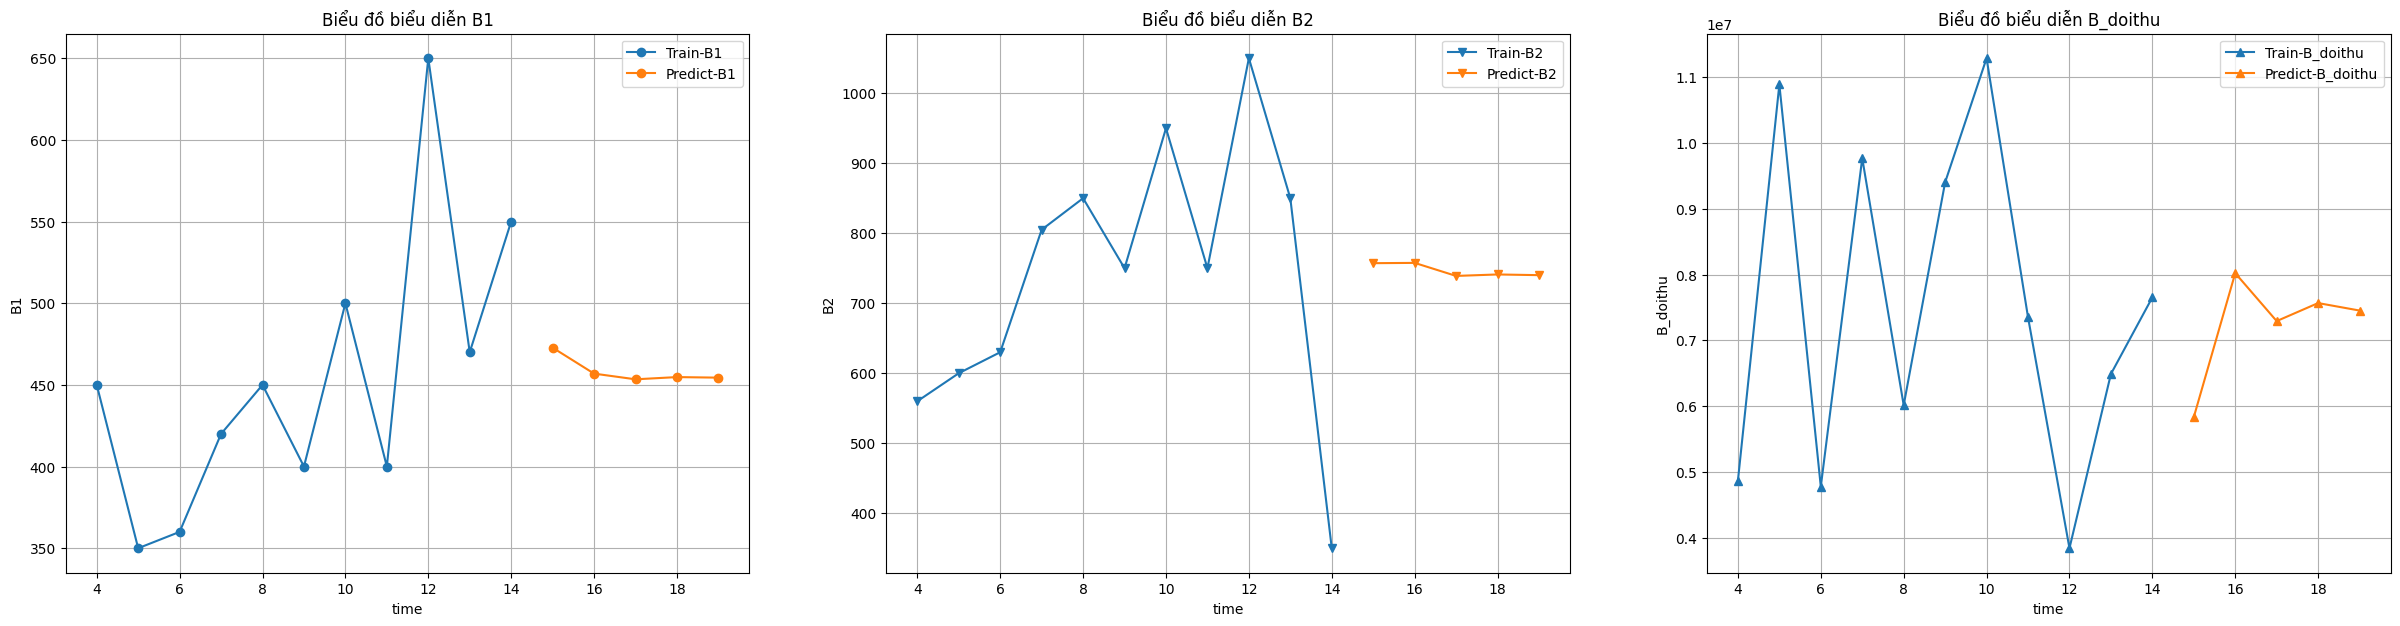

In [535]:
features = ['B1', 'B2', 'B_doithu']
data_use = data.iloc[4:15][features]
data_eval = data_test[features]
A, _, _, _, R = Yule_Walker(data_use, 1, step =1)
f = plot_evaluate(data_use, [],Yule_Walker_pre_train(A, pd.DataFrame(data_use), np.array(data_use.mean()), pre_len = 5))
Yule_Walker_pre_train(A, pd.DataFrame(data_use), np.array(data_use.mean()), pre_len = 5)